In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit, jacfwd, jacrev, grad, vmap
from jax.numpy.linalg import inv
from jax.nn import tanh, sigmoid, relu
from jax.experimental.ode import odeint

from scipy.optimize import minimize
from scipy.stats import norm

import matplotlib.pyplot as plt

np.random.seed(123)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-04_pflkn because the default path (/home/jaron/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# generate data from a ground truth ODE model (generalized Lotka-Volterra)

# number of species
n_s = 3 

# growth rates
r = np.random.uniform(.3, .5, n_s)

# interaction matrix
A = np.random.uniform(-.5, .3, size=[n_s, n_s])
for i in range(n_s):
    # self interaction is negative
    A[i, i] = -1.
    
# model parameters will be the latent variables to estimate later
z_true = jnp.append(r, A.flatten())

# function to reshape latent variables 
def reshape_z(z):
    r = z[:n_s]
    A = jnp.reshape(z[n_s:], [n_s, n_s])
    return r, A
    
# generalized Lotka Volterra model (gLV)
def gLV(x, t, z):
    r, A = reshape_z(z)
    return x*(r + jnp.einsum('ij,j->i', A, x))

# number of initial conditions 
n = 10
x0s = []
# monocultures
for i in range(n_s):
    mono = np.zeros(n_s)
    mono[i] = .1
    x0s.append(mono)
# communities
for i in range(n):
    x0s.append(np.random.uniform(0, .2, n_s))

# number of measurement times
m = 5

# time frame
t_span = jnp.linspace(0, 24, m)

# measurement noise (s = standard deviation and beta = precision)
s = 0.01
beta = (1./s)**2

# integrate gLV and add noise to generate simulated data
X = []
for x0 in x0s:
    # integrate ODE
    x = odeint(gLV, jnp.array(x0), t_span, z_true)
    
    # add noise after initial condition of inoculated species
    x = x.at[1:].set(x[1:] + s*np.random.randn(m-1, n_s))
    x = jnp.einsum('tk,k->tk', x, np.array(x[0]>0, int))
    
    # append to X
    X.append(x)

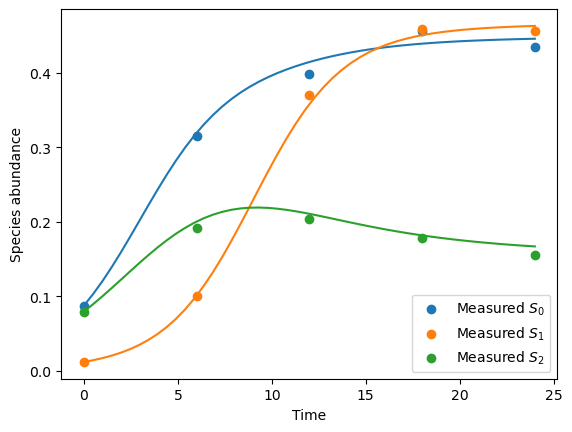

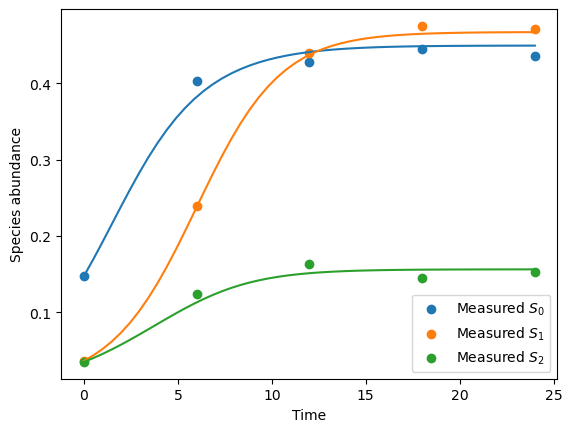

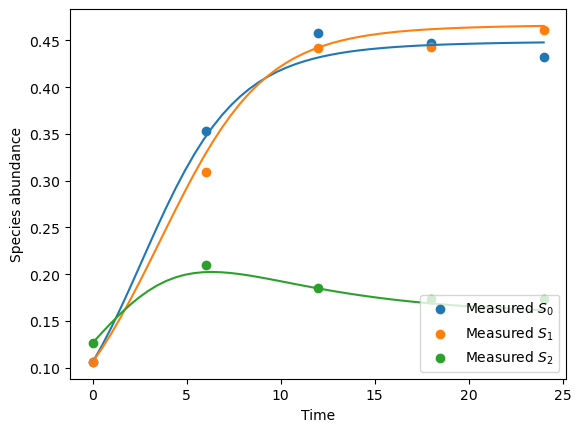

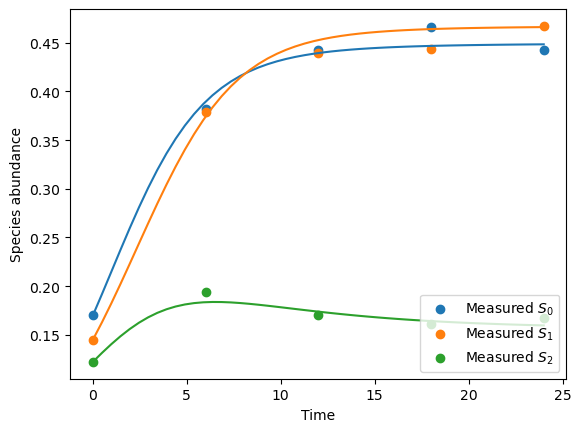

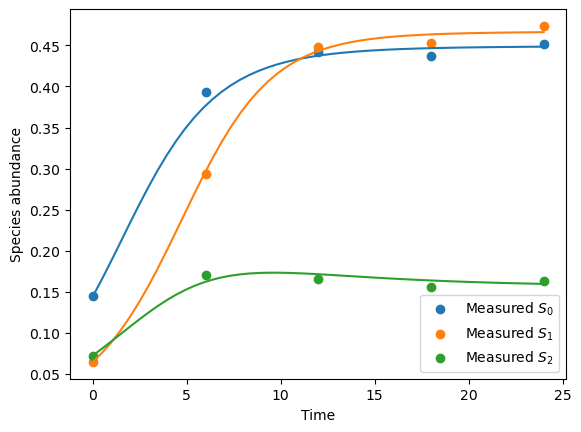

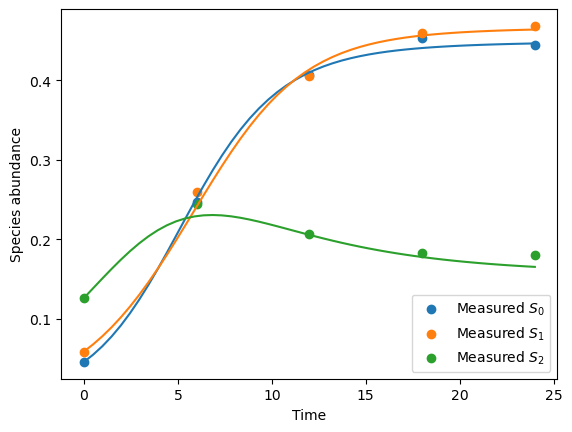

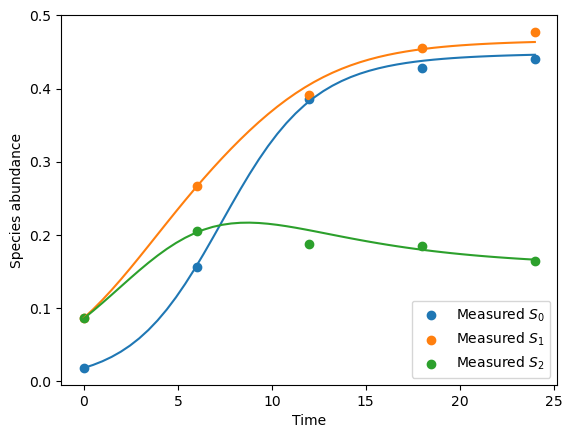

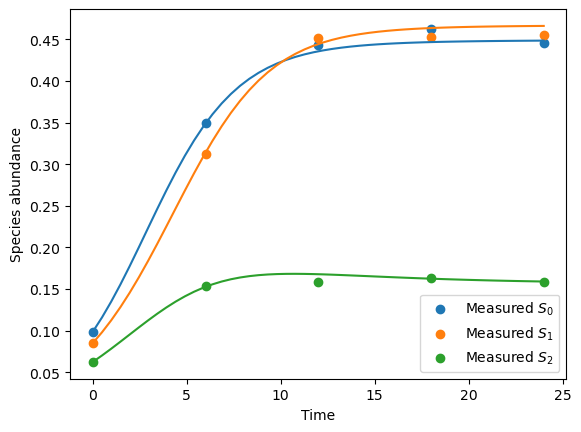

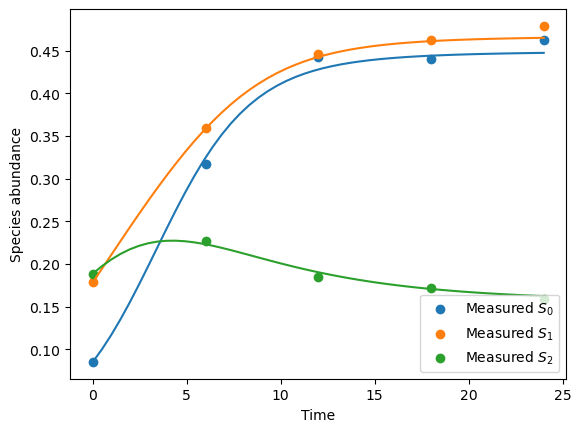

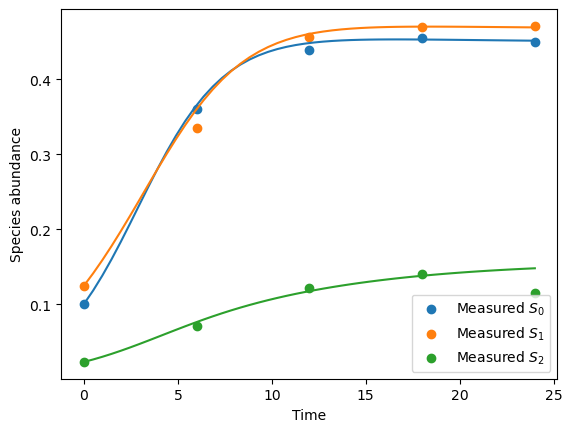

In [3]:
# plot data 
for i in range(n_s+n)[n_s:]:
    
    # integrate ODE
    x = odeint(gLV, X[i][0], np.linspace(t_span[0], t_span[-1]), z_true)

    # plt each species
    for j in range(n_s):
        if X[i][0,j] > 0:
            # plot data
            plt.scatter(t_span, X[i][:,j], c=f'C{j}', label=f"Measured $S_{j}$")
            plt.plot(np.linspace(t_span[0], t_span[-1]), x[:,j], c=f'C{j}')
    plt.legend(loc='lower right')
    plt.ylabel("Species abundance")
    plt.xlabel("Time")
    plt.show()

In [4]:
# generalized Lotka Volterra model (gLV)
@jit
def gLV(x, t, z):
    
    # modify output to make parameters make sense
    r, A = reshape_z(z)

    # make sure growth rates are positive
    r = jnp.exp2(r)/10.

    # make sure self interactions are negative
    for i in range(n_s):
        A = A.at[i,i].set(-jnp.exp2(A[i,i]))
    
    return x * (r + jnp.einsum('ij,j->i', A, x))

# define model that takes as input the initial condition the latent variables
@jit
def model(x, z):
    
    # integrate ODE
    t_hat = odeint(gLV, jnp.array(x[0]), t_span, z)
    
    # t_hat is the model estimate of observed variable t
    return t_hat[1:]

# gradient of model w.r.t. latent variables z
grad_model = jit(jacrev(model, 1))

# problem dimension
d = len(z_true)

# number of transformations
k = 25

# total number of parameters 
n_params = k * (2*d + 1)

# initial parameter values of normalizing flow
lmbda = np.random.randn(n_params) / d

# return list [[w1, u1, b1], ..., [wk, uk, bk]]
def reshape(params):
    params_list = []
    for i in range(k):
        params_list.append([params[i*(2*d+1):i*(2*d+1)+d], 
                            params[i*(2*d+1)+d:i*(2*d+1)+2*d], 
                            params[i*(2*d+1)+2*d]])
    return params_list

# jit compile functions used in planar flow model
m_func = jit(lambda x: jnp.log(1. + jnp.exp(x)) - 1.)
h = jit(lambda z, w, b: tanh(jnp.dot(w, z) + b))
psi = jit(grad(h))

@jit
def nn(y, lmbda):
    
    # weights and biases of nn
    for w, u, b in reshape(lmbda):
        # modify u to guarantee invertibility 
        wTu = jnp.dot(w, u)
        wTw = jnp.dot(w, w)
        u += w*(m_func(wTu) - wTu)/wTw
        
        # planar flow transformation
        y += u*h(y, w, b)
    
    return y 

# gradient of nn w.r.t. variational parameters lmbda
grad_nn = jit(jacfwd(nn, 1))

# batch eval of nn
batch_nn = jit(vmap(nn, (0, None)))

@jit
def log_det(y, lmbda):
    
    # weights and biases of nn
    log_det_val = 0.
    for w, u, b in reshape(lmbda):
        # modify u to guarantee invertibility 
        wTu = jnp.dot(w, u)
        wTw = jnp.dot(w, w)
        u += w*(m_func(wTu) - wTu)/wTw
        
        # compute log det
        log_det_val += jnp.log(jnp.abs(1. + jnp.dot(u, psi(y, w, b))))
        
        # update y
        y += u*h(y, w, b)
    
    return log_det_val

# evaluate log_det in batches
batch_log_det = jit(vmap(log_det, (0, None)))

# gradient of log abs det w.r.t. neural network parameters
grad_log_det = jit(jacrev(log_det, 1))

# gradient of entropy of approximating distribution w.r.t. lmbda
batch_grad_log_det = jit(jacrev(batch_log_det, 1))

# precision of Gaussian prior over z
alpha = .1

# set prior parameter mean on transformed variables
r_prior = np.log2(3.*np.ones(n_s))
A_prior = np.zeros([n_s, n_s])
for i in range(n_s):
    # self interaction
    A_prior[i, i] = np.log2(1.)
z_prior = jnp.append(r_prior, A_prior.flatten())

# evaluate log prior
@jit
def log_prior(y, lmbda):
    # map to sample from posterior
    z = nn(y, lmbda)
    
    # prior
    lp = alpha * jnp.sum((z-z_prior)**2) / 2.
    
    return lp

# eval log posterior in batches 
batch_log_prior = jit(vmap(log_prior, (0, None)))

# gradient of log posterior
grad_log_prior = jit(jacrev(log_prior, 1))

# gradient of log posterior
batch_grad_log_prior = jit(jacrev(batch_log_prior, 1))

# evaluate log likelihood 
@jit
def log_likelihood(y, x, lmbda):
    # map to sample from posterior
    z = nn(y, lmbda)
    # likelihood
    lp = beta * jnp.sum((x[1:] - model(x, z))**2) / 2. 
    
    return lp

# eval log posterior in batches 
batch_log_likelihood = jit(vmap(log_likelihood, (0, None, None)))

# gradient of log posterior w.r.t. variational parameters lmbda
grad_log_likelihood = jit(jacrev(log_likelihood, 2))

# batch evaluation of gradient of log posterior
batch_grad_log_likelihood = jit(jacrev(batch_log_likelihood, 2))

# slower but potentially more numerically stable gradient 
def grad_log_likelihood_slow(y, x, lmbda):
    # map to sample from posterior
    z = nn(y, lmbda)
    return beta * jnp.einsum('tk,tki,ij->j', model(x, z) - x[1:], grad_model(x, z), grad_nn(y, lmbda))

print(f"number of parameters in nn: {n_params}")

number of parameters in nn: 625


In [5]:
# ELBO cost function 
def elbo(lmbda, n_sample=10):
    
    # use nn to sample parameters
    y = np.random.randn(n_sample, d)
    
    # evaluate model fitness 
    '''ELBO = np.nanmean(batch_log_prior(y, lmbda), 0)
    for x in X:
        ELBO += np.nanmean(batch_log_likelihood(y, x, lmbda), 0)
    ELBO -= np.nanmean(batch_log_det(y, lmbda), 0)'''
    
    ELBO = 0.
    for yi in y:
        ELBO += np.nan_to_num(log_prior(yi, lmbda)) / n_sample
        for x in X:
            ELBO += np.nan_to_num(log_likelihood(yi, x, lmbda)) / n_sample
        ELBO -= np.nan_to_num(log_det(yi, lmbda)) / n_sample
    
    return ELBO

# gradient of ELBO cost function
def grad_elbo(lmbda, n_sample=10):
    
    # use nn to sample parameters
    y = np.random.randn(n_sample, d)
    
    # gradient 
    '''grad_ELBO = np.nanmean(batch_grad_log_prior(y, lmbda), 0)
    for x in X:
        grad_ELBO += np.nanmean(batch_grad_log_likelihood(y, x, lmbda), 0)
    grad_ELBO -= np.nanmean(batch_grad_log_det(y, lmbda), 0)'''
    
    grad_ELBO = 0.
    for yi in y:
        grad_ELBO += np.nan_to_num(grad_log_prior(yi, lmbda)) / n_sample
        for x in X:
            grad_ELBO += np.nan_to_num(grad_log_likelihood(yi, x, lmbda)) / n_sample
        grad_ELBO -= np.nan_to_num(grad_log_det(yi, lmbda)) / n_sample
    
    return grad_ELBO

In [6]:
# adam from chat gpt
def adam_optimizer(f, grad_f, initial_params, 
                   learning_rate=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8, 
                   max_iterations=1000, tol=1e-6):
    """
    ADAM optimizer for minimizing a function.

    Parameters:
    - grad_f: Gradient function that returns the gradient of the objective function.
    - initial_params: Initial guess for the parameters.
    - learning_rate: Step size for the optimization (default: 0.001).
    - beta1: Exponential decay rate for the first moment estimate (default: 0.9).
    - beta2: Exponential decay rate for the second moment estimate (default: 0.999).
    - epsilon: Small constant to prevent division by zero (default: 1e-8).
    - max_iterations: Maximum number of iterations (default: 1000).
    - tol: Tolerance to stop optimization when the change in parameters is below this value (default: 1e-6).

    Returns:
    - Optimal parameters.
    """
    params = initial_params
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    t = 0

    while t < max_iterations:
        t += 1
        print("ELBO: {:.3f}".format(elbo(params, n_sample=30)))

        gradient = grad_f(params)
        
        
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * (gradient ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        params -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        if np.linalg.norm(learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)) < tol:
            break

    return params

In [37]:
# optimize nn parameters
lmbda = adam_optimizer(elbo, grad_elbo, lmbda, learning_rate=1e-2)

ELBO: 373.068
ELBO: 5625.085
ELBO: 5554.895
ELBO: 3767.057
ELBO: 2229.060
ELBO: 2014.023
ELBO: 2141.261
ELBO: 2074.679
ELBO: 1353.909
ELBO: 1383.178
ELBO: 1555.304
ELBO: 1730.967
ELBO: 1639.113
ELBO: 1731.646
ELBO: 1540.603
ELBO: 1203.808
ELBO: 1296.868
ELBO: 1342.851
ELBO: 876.664
ELBO: 1020.757
ELBO: 1123.545
ELBO: 1155.891
ELBO: 885.041
ELBO: 912.587
ELBO: 736.446
ELBO: 806.030
ELBO: 840.071
ELBO: 823.545
ELBO: 962.400
ELBO: 853.386
ELBO: 841.655
ELBO: 867.580
ELBO: 783.247
ELBO: 799.897
ELBO: 764.366
ELBO: 626.113
ELBO: 768.703
ELBO: 791.615
ELBO: 779.429
ELBO: 750.559
ELBO: 661.258
ELBO: 697.814
ELBO: 633.401
ELBO: 585.683
ELBO: 651.507
ELBO: 774.332
ELBO: 662.238
ELBO: 641.098
ELBO: 724.382
ELBO: 660.149
ELBO: 581.255
ELBO: 537.899
ELBO: 659.338
ELBO: 593.822
ELBO: 671.930
ELBO: 683.812
ELBO: 531.390
ELBO: 471.360
ELBO: 935.374
ELBO: 508.310
ELBO: 528.539
ELBO: 641.080
ELBO: 586.466
ELBO: 572.020
ELBO: 495.553
ELBO: 533.076
ELBO: 542.525
ELBO: 584.647
ELBO: 431.180
ELBO: 529.732


ELBO: 196.177
ELBO: 287.209
ELBO: 196.060
ELBO: 299.269
ELBO: 206.918
ELBO: 204.581
ELBO: 207.395
ELBO: 178.382
ELBO: 192.117
ELBO: 194.594
ELBO: 186.445
ELBO: 207.981
ELBO: 192.286
ELBO: 188.525
ELBO: 237.936
ELBO: 202.574
ELBO: 201.746
ELBO: 201.667
ELBO: 167.136
ELBO: 200.238
ELBO: 223.218
ELBO: 174.173
ELBO: 166.262
ELBO: 186.732
ELBO: 222.419
ELBO: 215.354
ELBO: 243.291
ELBO: 184.005
ELBO: 203.615
ELBO: 267.770
ELBO: 246.638
ELBO: 237.557
ELBO: 194.061
ELBO: 248.229
ELBO: 174.862
ELBO: 190.532
ELBO: 217.043
ELBO: 193.464
ELBO: 205.872
ELBO: 195.398
ELBO: 187.583
ELBO: 205.977
ELBO: 218.189
ELBO: 186.848
ELBO: 157.364
ELBO: 226.530
ELBO: 205.953
ELBO: 184.966
ELBO: 194.957
ELBO: 221.603
ELBO: 229.484
ELBO: 205.508
ELBO: 225.025
ELBO: 191.496
ELBO: 189.287
ELBO: 201.178
ELBO: 186.985
ELBO: 187.050
ELBO: 234.345
ELBO: 257.297
ELBO: 218.500
ELBO: 187.867
ELBO: 187.420
ELBO: 169.758
ELBO: 190.322
ELBO: 183.196
ELBO: 178.407
ELBO: 172.472
ELBO: 179.263
ELBO: 168.352
ELBO: 194.858
ELBO: 

In [38]:
lmbda = adam_optimizer(elbo, grad_elbo, lmbda, learning_rate=1e-3)

ELBO: 184.347
ELBO: 203.083
ELBO: 216.809
ELBO: 194.312
ELBO: 179.747
ELBO: 171.590
ELBO: 159.176
ELBO: 190.364
ELBO: 195.683
ELBO: 143.177
ELBO: 147.735
ELBO: 178.079
ELBO: 173.373
ELBO: 158.963
ELBO: 176.278
ELBO: 154.156
ELBO: 152.982
ELBO: 168.645
ELBO: 165.725
ELBO: 153.187
ELBO: 185.703
ELBO: 153.082
ELBO: 163.770
ELBO: 170.531
ELBO: 159.481
ELBO: 158.280
ELBO: 149.793
ELBO: 185.348
ELBO: 158.953
ELBO: 142.207
ELBO: 146.864
ELBO: 152.429
ELBO: 145.835
ELBO: 161.422
ELBO: 152.666
ELBO: 154.696
ELBO: 175.341
ELBO: 143.596
ELBO: 160.074
ELBO: 153.275
ELBO: 164.845
ELBO: 169.300
ELBO: 142.361
ELBO: 143.191
ELBO: 152.758
ELBO: 139.851
ELBO: 141.214
ELBO: 141.641
ELBO: 148.809
ELBO: 148.819
ELBO: 153.495
ELBO: 150.949
ELBO: 141.032
ELBO: 152.811
ELBO: 144.036
ELBO: 144.123
ELBO: 152.671
ELBO: 142.528
ELBO: 148.218
ELBO: 140.967
ELBO: 151.758
ELBO: 150.854
ELBO: 149.539
ELBO: 148.285
ELBO: 135.361
ELBO: 136.242
ELBO: 150.704
ELBO: 146.320
ELBO: 168.797
ELBO: 146.327
ELBO: 135.200
ELBO: 

ELBO: 128.202
ELBO: 127.667
ELBO: 132.327
ELBO: 131.561
ELBO: 136.481
ELBO: 132.152
ELBO: 127.694
ELBO: 126.330
ELBO: 133.832
ELBO: 139.158
ELBO: 126.041
ELBO: 134.057
ELBO: 130.780
ELBO: 136.526
ELBO: 133.612
ELBO: 131.461
ELBO: 131.042
ELBO: 142.096
ELBO: 128.371
ELBO: 128.339
ELBO: 130.991
ELBO: 129.158
ELBO: 141.605
ELBO: 126.078
ELBO: 128.510
ELBO: 130.553
ELBO: 141.656
ELBO: 131.273
ELBO: 130.840
ELBO: 126.499
ELBO: 135.563
ELBO: 132.992
ELBO: 128.833
ELBO: 128.856
ELBO: 132.129
ELBO: 139.049
ELBO: 133.803
ELBO: 138.168
ELBO: 139.614
ELBO: 132.750
ELBO: 133.330
ELBO: 138.335
ELBO: 129.119
ELBO: 147.425
ELBO: 148.233
ELBO: 136.230
ELBO: 163.897
ELBO: 130.666
ELBO: 134.833
ELBO: 132.321
ELBO: 133.756
ELBO: 134.782
ELBO: 129.817
ELBO: 122.868
ELBO: 130.025
ELBO: 139.965
ELBO: 130.919
ELBO: 163.561
ELBO: 128.365
ELBO: 172.624
ELBO: 127.486
ELBO: 135.221
ELBO: 127.324
ELBO: 133.280
ELBO: 130.881
ELBO: 137.449
ELBO: 131.985
ELBO: 127.731
ELBO: 145.160
ELBO: 134.862
ELBO: 135.463
ELBO: 

In [33]:
lmbda = adam_optimizer(elbo, grad_elbo, lmbda, learning_rate=1e-5)

ELBO: 389.713
ELBO: 425.501
ELBO: 398.801
ELBO: 370.033
ELBO: 449.025
ELBO: 393.332
ELBO: 410.741
ELBO: 419.599
ELBO: 387.255
ELBO: 406.185
ELBO: 388.468
ELBO: 407.700
ELBO: 391.595
ELBO: 381.723
ELBO: 423.215
ELBO: 421.388
ELBO: 412.054
ELBO: 378.119
ELBO: 365.637
ELBO: 385.895
ELBO: 429.918
ELBO: 364.433
ELBO: 413.635
ELBO: 460.105
ELBO: 373.078
ELBO: 398.618
ELBO: 375.496
ELBO: 402.326
ELBO: 364.347
ELBO: 435.536
ELBO: 392.529
ELBO: 574.565
ELBO: 428.267
ELBO: 423.644
ELBO: 385.997
ELBO: 387.636
ELBO: 402.168
ELBO: 402.907
ELBO: 394.493
ELBO: 372.913
ELBO: 401.202
ELBO: 373.491
ELBO: 378.589
ELBO: 384.080
ELBO: 414.357
ELBO: 389.496
ELBO: 441.477
ELBO: 376.237
ELBO: 371.451
ELBO: 379.091
ELBO: 399.513
ELBO: 383.984
ELBO: 419.532
ELBO: 422.022
ELBO: 395.237
ELBO: 357.629
ELBO: 407.330
ELBO: 390.992
ELBO: 365.461
ELBO: 446.197
ELBO: 410.324
ELBO: 414.450
ELBO: 383.985
ELBO: 428.246
ELBO: 396.911
ELBO: 442.245
ELBO: 386.943
ELBO: 395.185
ELBO: 456.926
ELBO: 548.945
ELBO: 420.440
ELBO: 

ELBO: 388.976
ELBO: 399.823
ELBO: 386.164
ELBO: 406.190
ELBO: 396.543
ELBO: 428.942
ELBO: 467.128
ELBO: 403.415
ELBO: 387.778
ELBO: 379.000
ELBO: 394.918
ELBO: 414.385
ELBO: 369.843
ELBO: 378.743
ELBO: 413.413
ELBO: 406.793
ELBO: 426.698
ELBO: 403.648
ELBO: 390.298
ELBO: 422.393
ELBO: 386.975
ELBO: 355.926
ELBO: 463.778
ELBO: 367.809
ELBO: 381.423
ELBO: 346.702
ELBO: 391.161
ELBO: 422.027
ELBO: 395.227
ELBO: 400.259
ELBO: 415.037
ELBO: 374.043
ELBO: 386.792
ELBO: 389.733
ELBO: 413.576
ELBO: 378.168
ELBO: 429.741
ELBO: 411.718
ELBO: 394.442
ELBO: 396.693
ELBO: 411.528
ELBO: 391.743
ELBO: 410.655
ELBO: 404.165
ELBO: 350.455
ELBO: 366.992
ELBO: 425.773
ELBO: 423.722
ELBO: 402.490
ELBO: 423.374
ELBO: 378.845
ELBO: 537.870
ELBO: 377.716
ELBO: 397.857
ELBO: 388.017
ELBO: 399.101
ELBO: 445.469
ELBO: 417.167
ELBO: 364.862
ELBO: 395.414
ELBO: 428.097
ELBO: 438.955
ELBO: 420.397
ELBO: 354.398
ELBO: 407.864
ELBO: 384.526
ELBO: 472.613
ELBO: 426.277
ELBO: 414.570
ELBO: 446.493
ELBO: 411.499
ELBO: 

In [39]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(2000, d)
z = batch_nn(y, lmbda)

In [40]:
# transform to correct z vale
def z_transform(z):
    # modify output to make parameters make sense
    r, A = reshape_z(z)

    # make sure growth rates are positive
    r = jnp.exp2(r)/10.

    # make sure self interactions are negative
    for i in range(n_s):
        A = A.at[i,i].set(-jnp.exp2(A[i,i]))
        
    return jnp.append(r, A.flatten())

batch_z_transform = jit(vmap(z_transform))
z = batch_z_transform(z)

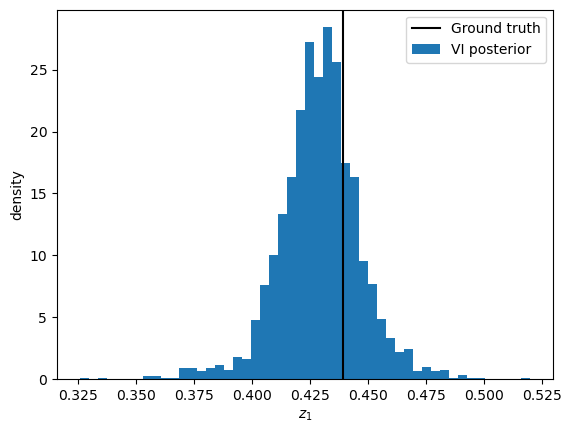

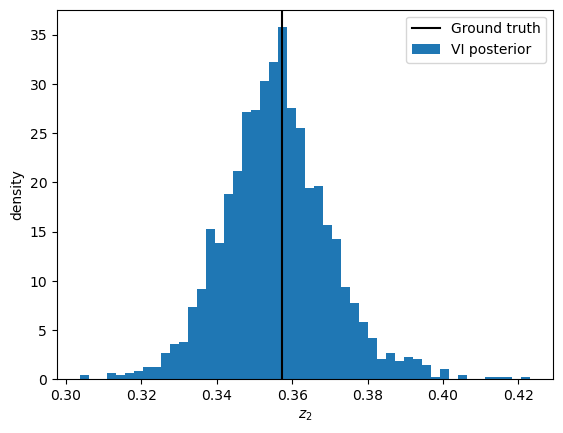

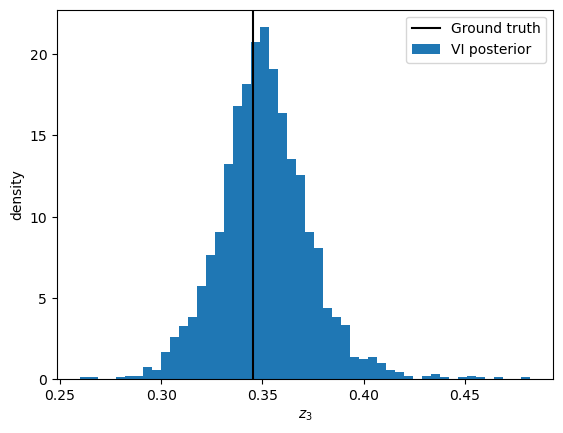

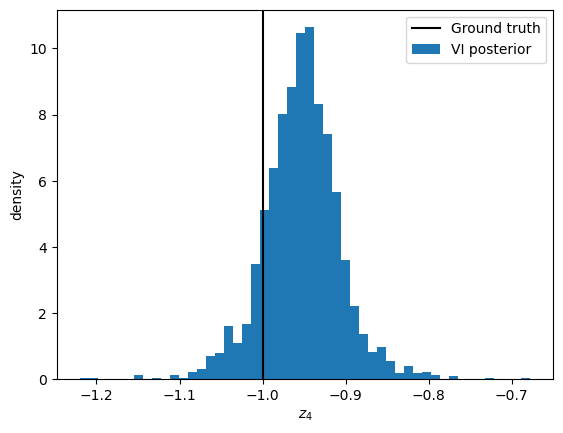

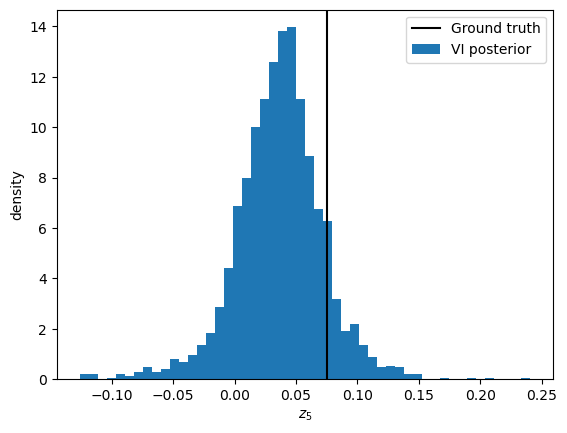

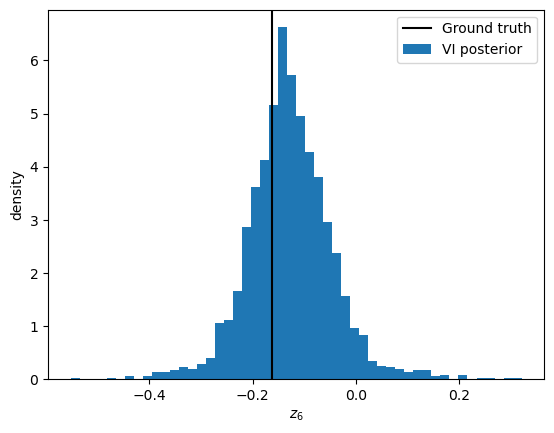

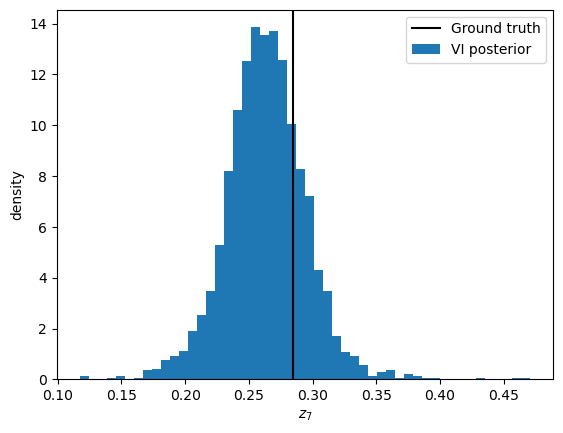

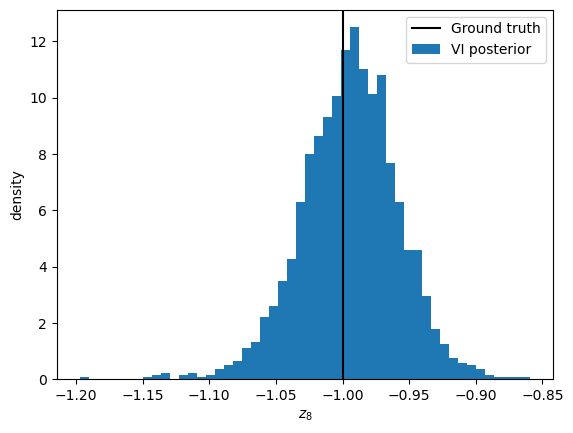

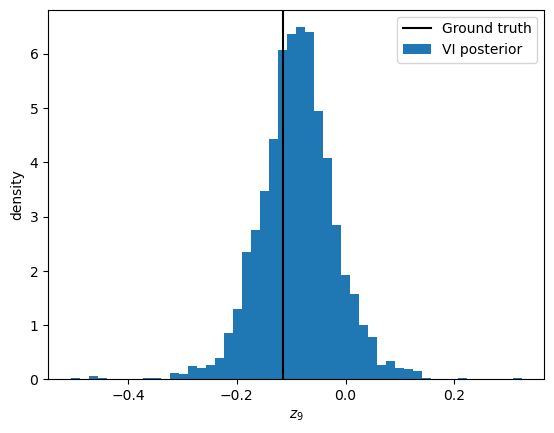

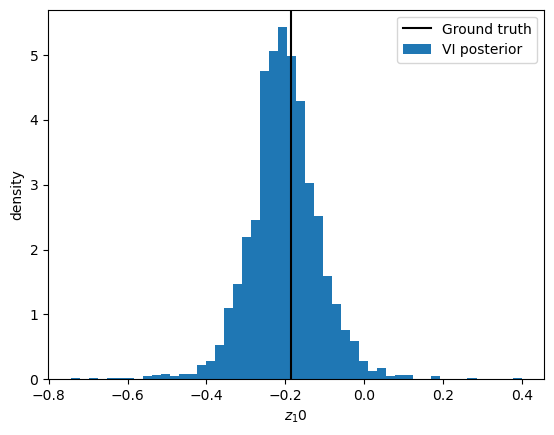

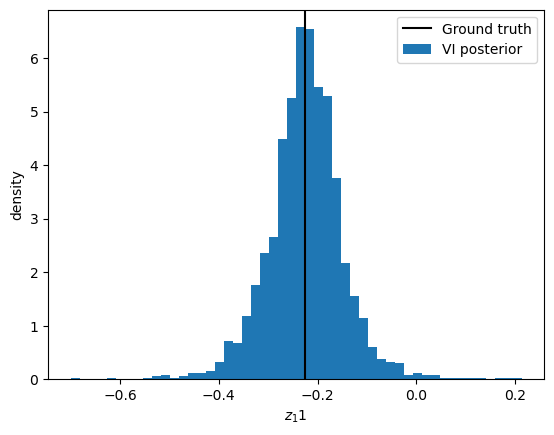

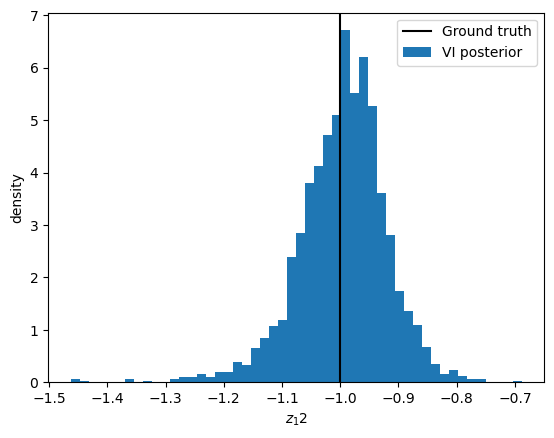

In [41]:
for i, z_true_i in enumerate(z_true):
    
    # plot NN posterior 
    plt.hist(np.array(z[:, i]), color='C0', bins=50, density=True, label='VI posterior')
    plt.axvline(x=z_true_i, c='k', label='Ground truth')
    
    plt.xlabel(f"$z_{i+1}$")
    plt.ylabel("density")
    plt.legend()
    plt.show()

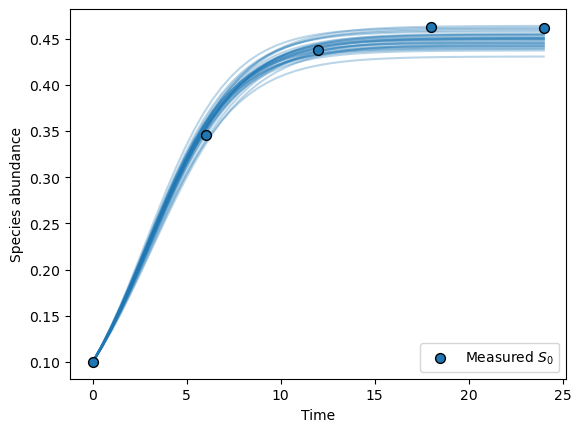

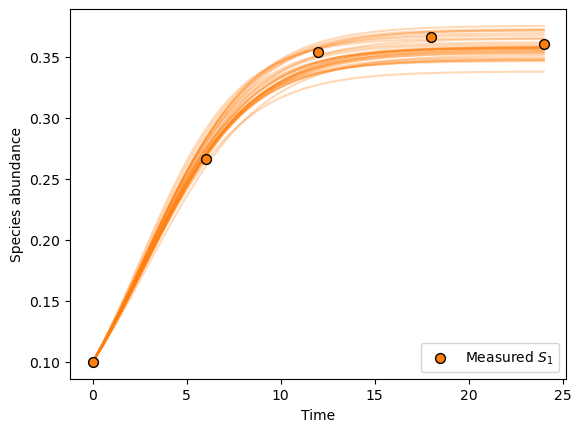

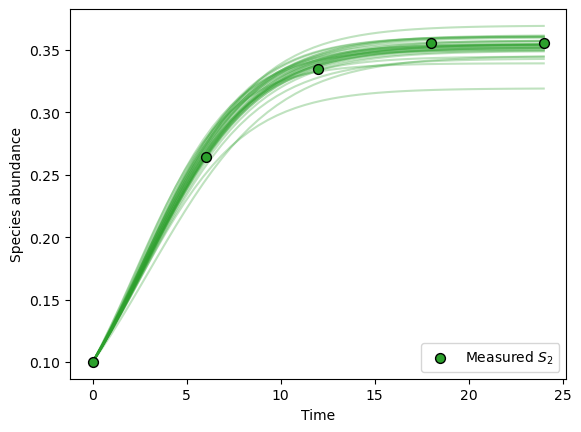

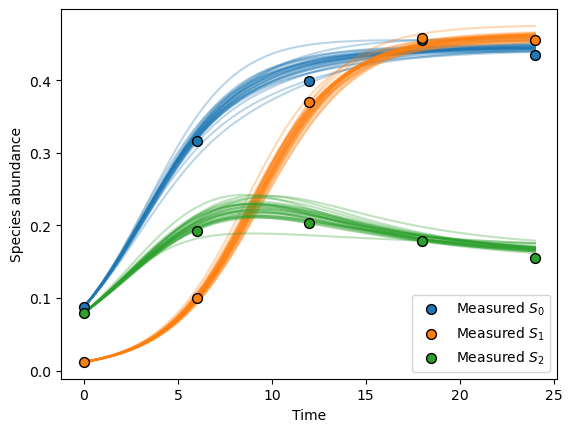

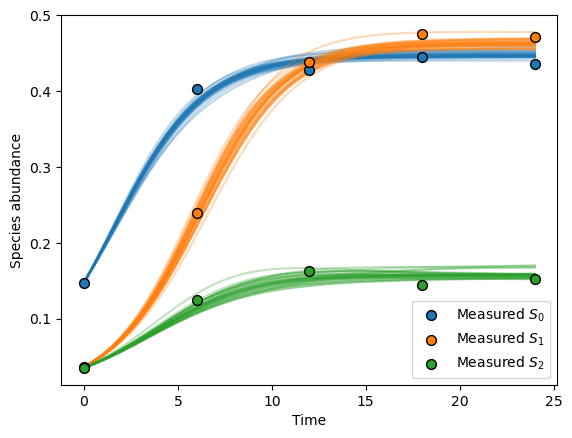

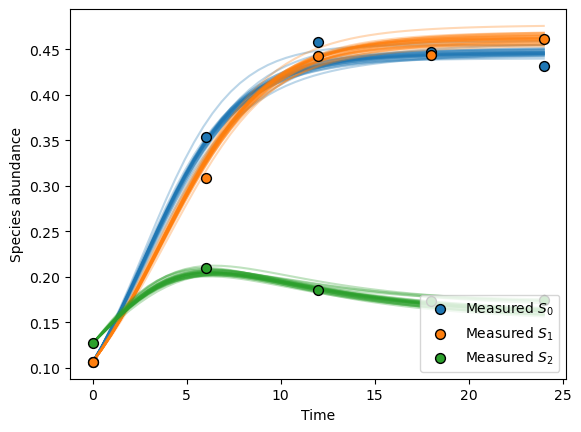

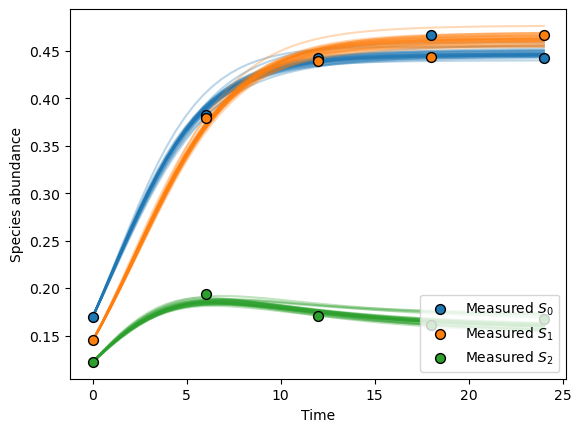

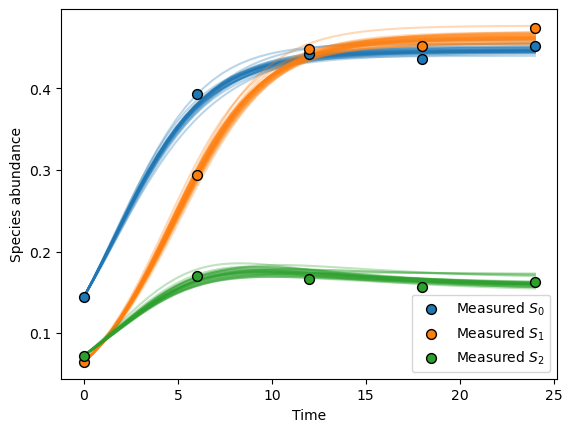

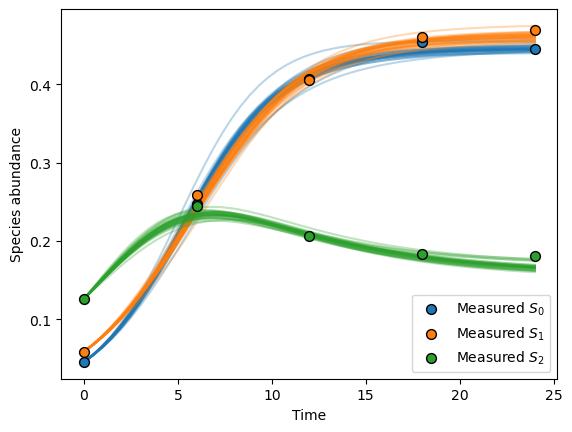

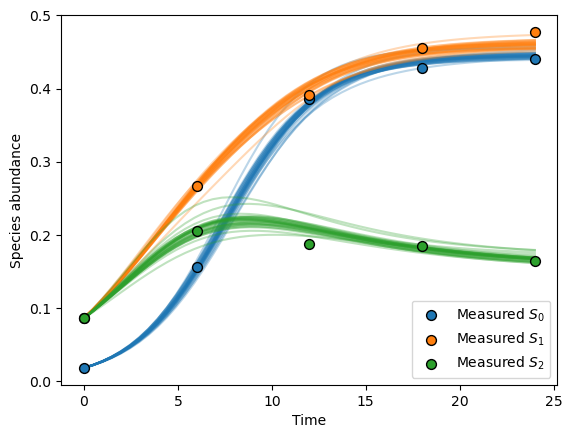

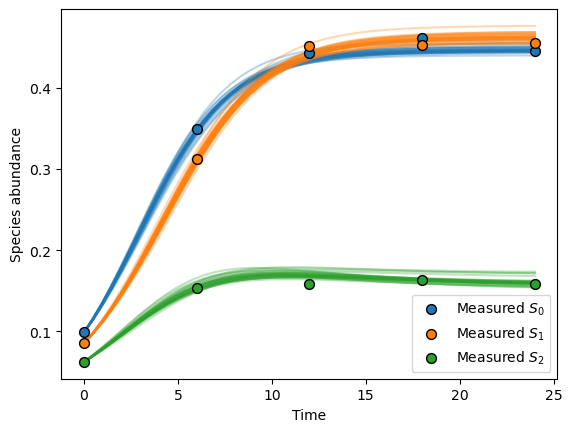

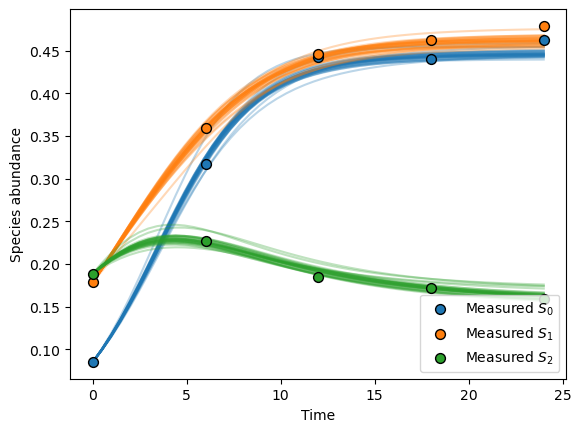

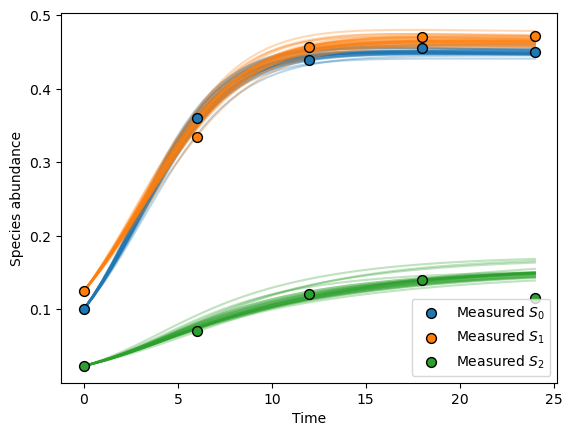

In [42]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(30, d)
z = batch_nn(y, lmbda)

# plot data 
for i in range(n_s+n):

    # plt each species
    for j in range(n_s):
        if X[i][0,j] > 0:
            # plot data
            plt.scatter(t_span, X[i][:,j], c=f'C{j}', label=f"Measured $S_{j}$",
                        zorder=1, edgecolor='k', s=50)
            
            # plot samples from posterior
            for z_sample in z:
                x = odeint(gLV, X[i][0], np.linspace(t_span[0], t_span[-1]), z_sample)
                plt.plot(np.linspace(t_span[0], t_span[-1]), x[:,j], c=f'C{j}', alpha=.3, zorder=0)
    plt.legend(loc='lower right')
    plt.ylabel("Species abundance")
    plt.xlabel("Time")
    plt.show()

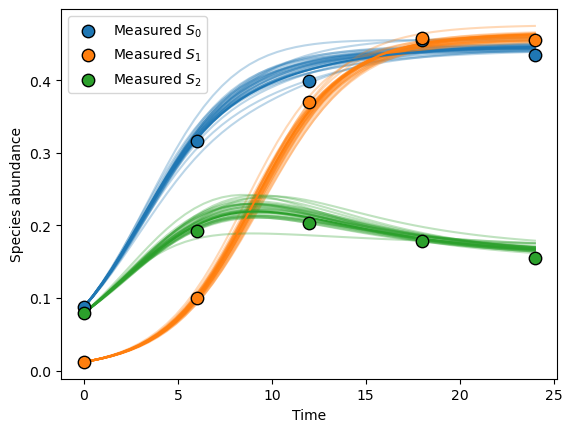

In [43]:
# pick condition
i = 3

# generalized Lotka Volterra model (gLV)
def gLV_gt(x, t, z):
    r, A = reshape_z(z)
    return x*(r + jnp.einsum('ij,j->i', A, x))

# plt each species
for j in range(n_s):
    if X[i][0,j] > 0:
        # plot data
        plt.scatter(t_span, X[i][:,j], c=f'C{j}', label=f"Measured $S_{j}$",
                    zorder=2, edgecolor='k', s=80)

        # ground truth
        x = odeint(gLV_gt, X[i][0], np.linspace(t_span[0], t_span[-1]), z_true)
        plt.plot(np.linspace(t_span[0], t_span[-1]), x[:,j], c=f'C{j}', alpha=1., zorder=1)
        
        # plot samples from posterior
        for z_sample in z:
            x = odeint(gLV, X[i][0], np.linspace(t_span[0], t_span[-1]), z_sample)
            plt.plot(np.linspace(t_span[0], t_span[-1]), x[:,j], c=f'C{j}', alpha=.3, zorder=0)
plt.legend(loc='upper left')
plt.ylabel("Species abundance")
plt.xlabel("Time")
plt.savefig("figures/gLV_example.png")
plt.show()